In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("C:/Users/HP/Desktop/MILL FOLDER/milling_machine_conditions_with_tool_wear_seconds.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Air Temp (°C)           10000 non-null  float64
 1   Process Temp (°C)       10000 non-null  float64
 2   Rotational Speed (RPM)  10000 non-null  float64
 3   Torque (Nm)             10000 non-null  float64
 4   Tool Wear (Seconds)     10000 non-null  float64
 5   Target                  10000 non-null  int64  
 6   Failure Types           10000 non-null  object 
dtypes: float64(5), int64(1), object(1)
memory usage: 547.0+ KB
None
       Air Temp (°C)  Process Temp (°C)  Rotational Speed (RPM)   Torque (Nm)  \
count   10000.000000       10000.000000            10000.000000  10000.000000   
mean       28.518531          80.808539             1401.909988     46.998845   
std         7.721187          15.556126              968.446183     26.747646   
min        20.001366   

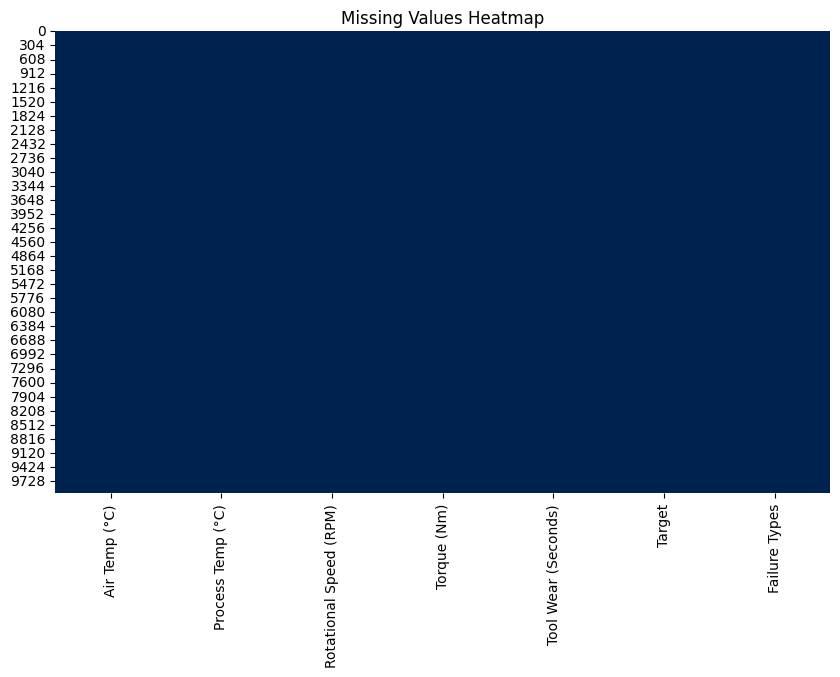

In [21]:
print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df.duplicated().sum())

# Optional: visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), cbar=False, cmap='cividis')
plt.title("Missing Values Heatmap")
plt.show()


In [22]:
from sklearn.preprocessing import LabelEncoder

# Label encode 'Failure Types'
le = LabelEncoder()
df['new_Failure Types'] = le.fit_transform(df['Failure Types'])

# Drop unnecessary columns
df.drop(['Failure Types', 'Target'], axis=1, inplace=True)


In [23]:
X = df.drop(['new_Failure Types'], axis=1)
y = df['new_Failure Types']


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [25]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Apply SMOTE only on training set
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       395
           1       1.00      1.00      1.00       410
           2       1.00      1.00      1.00       415
           3       1.00      1.00      1.00       393
           4       1.00      1.00      1.00       387

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



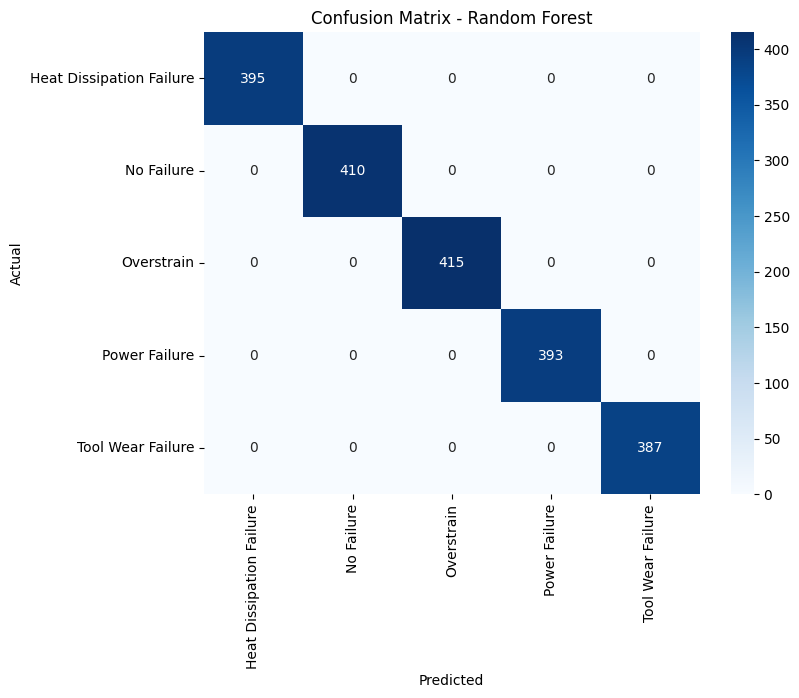

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_res, y_res)
y_pred = rfc.predict(X_test)

print(classification_report(y_test, y_pred))

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Tuned Random Forest Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       395
           1       1.00      1.00      1.00       410
           2       1.00      1.00      1.00       415
           3       1.00      1.00      1.00       393
           4       1.00      1.00      1.00       387

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



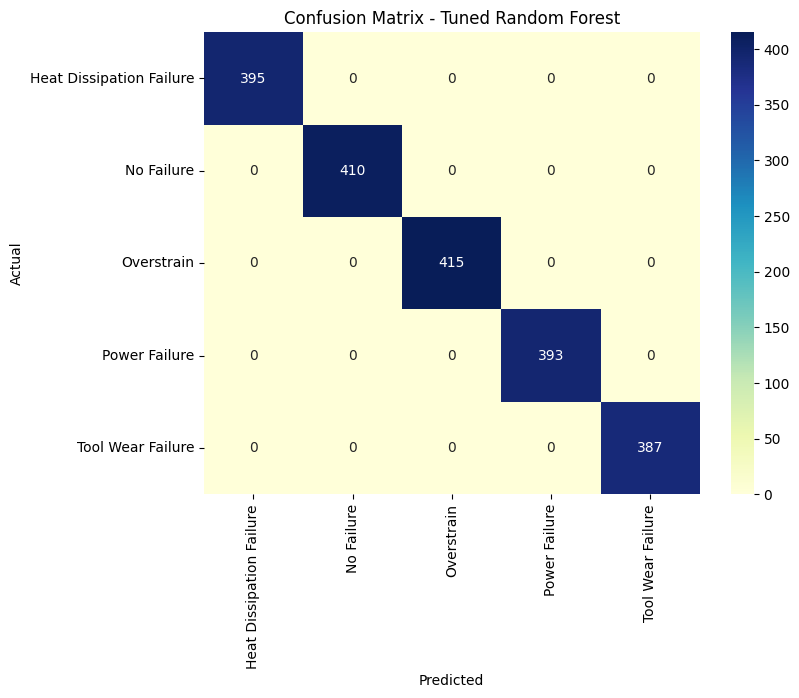

In [27]:
# Step 7: Hyperparameter Tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid,
                    cv=5,
                    scoring='accuracy',
                    n_jobs=-1)

grid.fit(X_res, y_res)

print("Best Parameters:", grid.best_params_)

# Evaluate the best model
best_rfc = grid.best_estimator_
y_best_pred = best_rfc.predict(X_test)

print("Tuned Random Forest Report:\n", classification_report(y_test, y_best_pred))

# Confusion Matrix for best model
best_cm = confusion_matrix(y_test, y_best_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
y_best_pred = best_rfc.predict([[29.021640,	71.620737,	1515.840689,	50.223021,	664.638000]])
y_best_pred


array([2])

: 

: 

In [28]:
import joblib

# Save the best model
joblib.dump(best_rfc, "tuned_random_forest_model.pkl")
print("Model saved as 'tuned_random_forest_model.pkl'")


Model saved as 'tuned_random_forest_model.pkl'


In [29]:
# Load the model when needed
loaded_model = joblib.load("tuned_random_forest_model.pkl")

# Predict using the loaded model
sample = [[29.021640, 71.620737, 1515.840689, 50.223021, 664.638000]]  # Example input
sample_scaled = scaler.transform(sample)
prediction = loaded_model.predict(sample_scaled)
print("Predicted Failure Type:", le.inverse_transform(prediction))


Predicted Failure Type: ['No Failure']


c:\Users\HP\Desktop\NEW DIABETES\peaceenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [30]:
sample2 = [[23.223389,	86.260566,	548.189837,	34.266373,	30506.579732]]
sample_scaled = scaler.transform(sample2)
prediction = loaded_model.predict(sample_scaled)
print('Predicted Failure Type:', le.inverse_transform(prediction))

Predicted Failure Type: ['Tool Wear Failure']


c:\Users\HP\Desktop\NEW DIABETES\peaceenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [31]:
# After fitting
joblib.dump(scaler, "scaler.pkl")       # This scaler was fitted using scaler.fit_transform(X)
joblib.dump(le, "label_encoder.pkl")    # This label encoder was fitted using le.fit(df['Failure Types'])


['label_encoder.pkl']